Let's get started by installing the relevant dependencies:

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=1d32a761eafd26d82b134a31ae8c81813a0f7479f08ed2db4686e43d5581bd43
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


## 2.1 Datasets

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
[Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system, with each image labeled as "Lighter'' or "Darker''.



In [2]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263902720/1263889489 [==============================] - 19s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


In [3]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

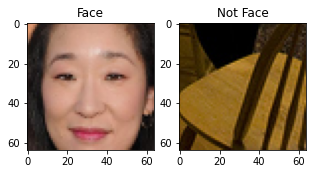

In [4]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 11 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 4 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

## 2.2 CNN for facial detection 

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method.

In [5]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

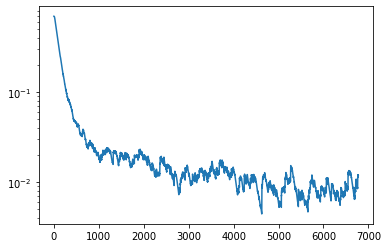

100%|██████████| 3434/3434 [00:58<00:00, 58.81it/s]


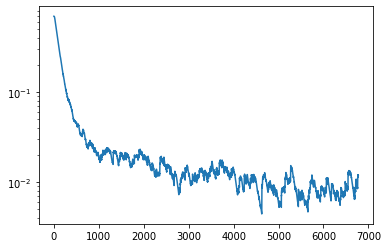

In [6]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.


In [7]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) training set: 0.9960


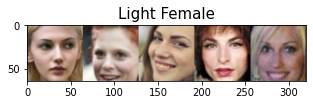

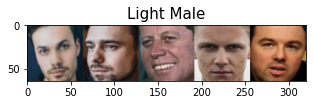

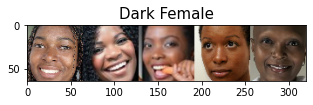

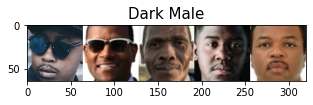

In [8]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained.

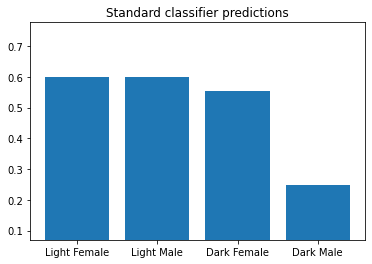

In [9]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

## 2.3 Mitigating algorithmic bias

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

How could we overcome this? A naive solution -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then manually even out the data with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different features that are imbalanced within the training data.

Instead, let's actually **learn** these features in an unbiased, unsupervised manner, without the need for any annotation, and then train a classifier fairly with respect to these features. In the rest of this lab, we'll do exactly that.

### Understanding VAEs: loss function

we train a VAE using learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization.

In [10]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Understanding VAEs: reparameterization 

Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim \mathcal{N}(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [11]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim)) 
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  return z

### Defining the DB-VAE loss function

 The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable $\mathcal{I}_f$which reflects which training data are images of faces ($\mathcal{I}_f(y) = 1$ ) and which are images of non-faces ($\mathcal{I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + \mathcal{I}_f(y)\Big[L_{VAE}\Big]$$



In [13]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
 
  return total_loss, classification_loss

In [14]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [15]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [16]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [17]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    mu = get_latent_mu(images, dbvae)
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
     
        training_sample_p = np.maximum(p, training_sample_p)
       
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

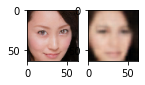

 15%|█▍        | 499/3434 [00:06<00:36, 81.51it/s]

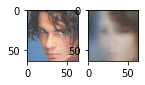

 29%|██▉       | 993/3434 [00:13<00:31, 78.57it/s]

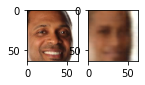

 44%|████▎     | 1497/3434 [00:19<00:24, 79.71it/s]

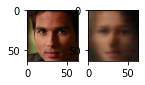

 58%|█████▊    | 1993/3434 [00:26<00:18, 78.49it/s]

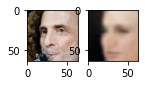

 73%|███████▎  | 2498/3434 [00:33<00:12, 76.58it/s]

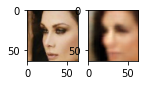

 87%|████████▋ | 2999/3434 [00:39<00:06, 72.03it/s]

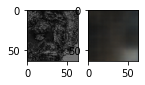

100%|██████████| 3434/3434 [00:45<00:00, 75.16it/s]


In [18]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, dbvae.trainable_variables)

  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  
  p_faces = get_training_sample_probabilities(all_faces, dbvae)  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

## 2.6 Evaluation of DB-VAE on Test Dataset


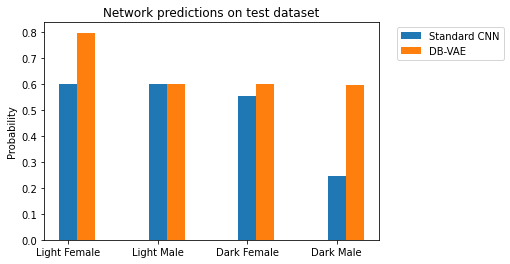

In [19]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
